This notebook replaces all others, and is intended as the single source of truth for the de Berker et al., stroke paper.

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks", color_codes=True)
#flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
#sns.set_palette(sns.color_palette(flatui))
sns.__version__

'0.9.0'

## 1. Basic data analysis

In [70]:
df = pd.read_excel('../data/Discharge destinations 2.xlsx', 
                   sheet_name='Regression analysis',
                  header=2)

df.reset_index(inplace=True)
df.drop(['index', 'Key'], axis=1, inplace=True)
outcome_dict={0:'Death', 1:'Inpatient', 2:'CH', 3:'Home'}
df['Outcome']=df['Outcome'].map(lambda x: outcome_dict[x])
df.drop('Unnamed: 0', axis=1, inplace=True)

In [71]:
df.head()

,Age,NIHSS,MRS,Outcome
0,66,22,1,Death
1,83,15,4,Death
2,83,21,2,Death
3,81,24,1,Death
4,81,21,1,Death


The pairplot shows all the differnet relationships in the data in one place.

Here we can see:

1. All groups are fairly similar in age, although CH are perhaps on average slightly older and inpatients younger.
2. Low NIHSS scores are associated with death or inpatiency. Higher scores correspond to Home.
3. Low MRS scores seem to be associated with death, whilst high ones are associated with community hospital.

The scatter plots are a bit confusing, but it seems like MRS and age are positivel correlated. NIHSS and MRS are unclear.

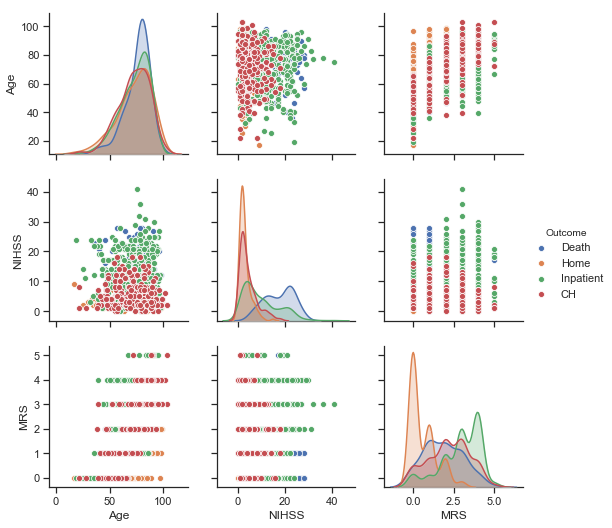

In [72]:
sns.pairplot(df, hue='Outcome')

## Digging into correlations between predictors

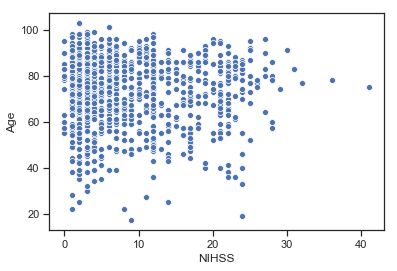

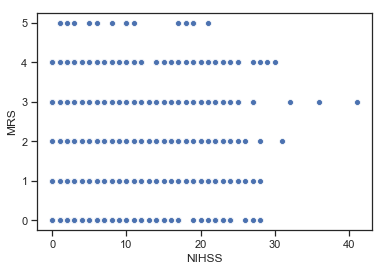

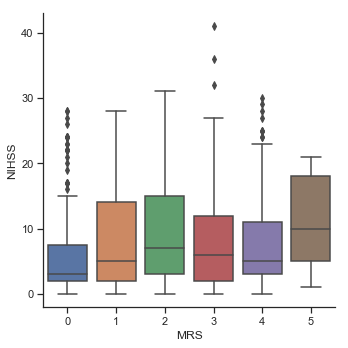

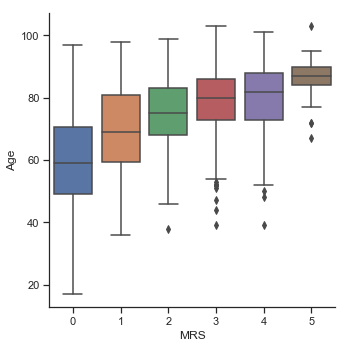

In [73]:
sns.scatterplot(x='NIHSS', y='Age', data=df)
plt.show()
sns.scatterplot(x='NIHSS', y='MRS', data=df)
plt.show()
sns.catplot(x="MRS", y="NIHSS", kind="box", data=df)
sns.catplot(x="MRS", y="Age", kind="box", data=df)

From this, it seems:
    
1. MRS and NIHSS are surprisingly unrelated
2. MRS is strongly related to age
3. NIHSS seems unrelated to age

Indeed, this is supported by the raw correlations:

In [74]:
df.corr()

,Age,NIHSS,MRS
Age,1.000000,-0.036907,0.482974
NIHSS,-0.036907,1.000000,0.035380
MRS,0.482974,0.035380,1.000000


## Separating predictors by group

NIHSS seems to have clear signal. Higher NIHSS scores are bad news.

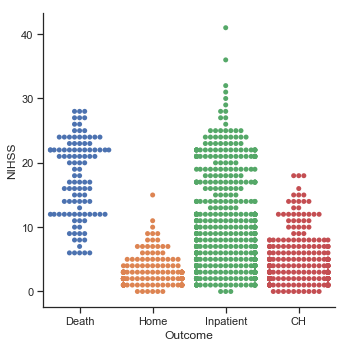

In [78]:
sns.catplot(x="Outcome", y="NIHSS", kind="swarm", data=df)

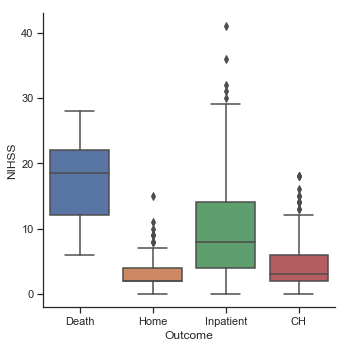

In [79]:
sns.catplot(x="Outcome", y="NIHSS", kind="box", data=df)

MRS is much harder to interpret. Oddly, death is associated with low MRS scores.

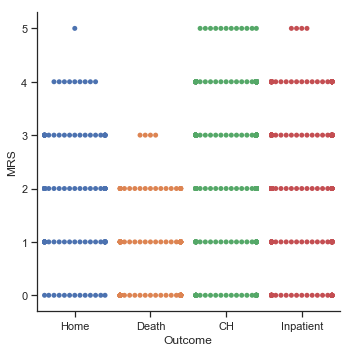

In [40]:
sns.catplot(x="Outcome", y="MRS", kind="swarm", data=df)

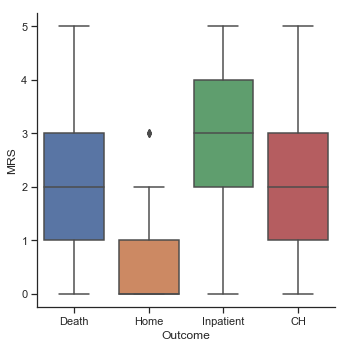

In [80]:
sns.catplot(x="Outcome", y="MRS", kind="box", data=df)

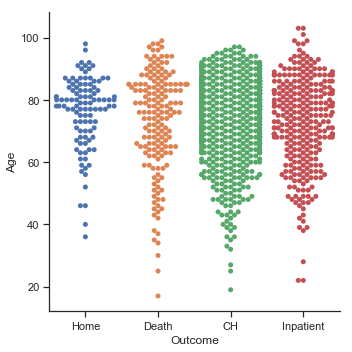

In [43]:
sns.catplot(x="Outcome", y="Age", kind="swarm", data=df)

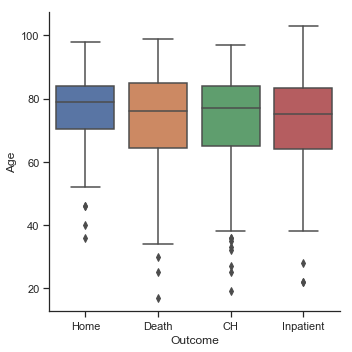

In [44]:
sns.catplot(x="Outcome", y="Age", kind="box", data=df)

## 2. Univariate stats


ANOVAs confirm that MRS and NIHSS both have singal about destination, whereas age alone does not.

In [55]:
from scipy import stats
 
F, p = stats.f_oneway(df.loc[df['Outcome']=='Home','MRS'],  

                      df.loc[df['Outcome']=='Inpatient','MRS']) 
                      

In [58]:
stats.ttest_ind(df.loc[df['Outcome']=='Home','MRS'],
               df.loc[df['Outcome']=='Inpatient','MRS'])

stats.ttest_ind(df.loc[df['Outcome']=='Home','MRS'],
               df.loc[df['Outcome']=='Death','MRS'])




Ttest_indResult(statistic=10.870295199636661, pvalue=3.924708284231303e-23)

In [59]:
F, p = stats.f_oneway(df.loc[df['Outcome']=='Home','Age'], 
                      df.loc[df['Outcome']=='Death','Age'], 
                      df.loc[df['Outcome']=='CH','Age'], 
                      df.loc[df['Outcome']=='Inpatient','Age']) 
                      

In [60]:
p

0.18696912412664338

In [61]:
F, p = stats.f_oneway(df.loc[df['Outcome']=='Home','NIHSS'], 
                      df.loc[df['Outcome']=='Death','NIHSS'], 
                      df.loc[df['Outcome']=='CH','NIHSS'], 
                      df.loc[df['Outcome']=='Inpatient','NIHSS']) 
                      

In [62]:
p

7.668996501300211e-100